# Recommendations with IBM (Udacity Project)

In this notebook, we create a recommendations engine using on real data from the IBM Watson Studio platform. 

We use a number of different methods for making recommendations that can be used for different situations. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [3]:
pd.set_option('display.min_rows', 20)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` __What is the distribution of how many articles a user interacts with in the dataset?__

We provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
df[df.email.isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


In [5]:
print(f'Number of user-item interactions: {df.shape[0]}')
print(f'Number of unique users (excluding NaNs): {df.email.nunique()}')
print(f'Number of repeated user-item interactions (users that interacted 1+ with articles): {df.duplicated().sum()}')

Number of user-item interactions: 45993
Number of unique users (excluding NaNs): 5148
Number of repeated user-item interactions (users that interacted 1+ with articles): 12311


In [6]:
print(f'There are {df.email.isnull().sum()} null user_ids')

There are 17 null user_ids


In [7]:
# Given a user compute how many interactions per article
inter_per_article = df.groupby(['email','article_id']).article_id.agg(
                            interactions='count',
                        )
inter_per_article.head(15)

interactions
email                                    article_id              
0000b6387a0366322d7fbfc6434af145adf7fed1 43.0                   2
                                         124.0                  1
                                         173.0                  1
                                         288.0                  1
                                         349.0                  1
                                         618.0                  1
                                         732.0                  1
                                         1162.0                 1
                                         1232.0                 1
                                         1314.0                 1
                                         1337.0                 1
                                         1354.0                 1
001055fc0bb67f71e8fa17002342b256a30254cd 124.0                  1
                                         254.0                  1
                                         390.0                  1

In [8]:
# Given a user compute mean interactions per article
# We would expect a number close to 1 (few times that the user reads same article more than once)
user_interact = df.groupby(['email']).article_id.agg(
                            total_interactions='count',
                            distinct_articles='nunique',
                            mean_interactions=lambda x: x.count()/x.nunique()
                        )
user_interact.sort_values(['total_interactions','distinct_articles'], ascending=False, inplace=True)
user_interact.head()

,total_interactions,distinct_articles,mean_interactions
email,,,
2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364,135,2.696296
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363,135,2.688889
2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170,97,1.752577
a37adec71b667b297ed2440a9ff7dad427c7ac85,169,97,1.742268
8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160,96,1.666667


In [9]:
(user_interact.total_interactions==1).sum()

1416

In [10]:
sns.set(rc={'figure.figsize':(16,6)})

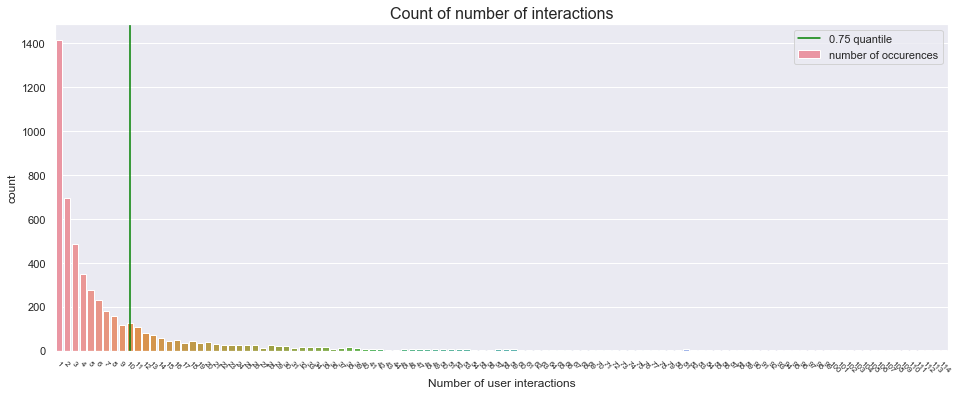

In [11]:
fig, ax = plt.subplots()
c = sns.countplot(x='total_interactions', data=user_interact, ax=ax)
ax.set_xlabel('Number of user interactions')
ax.set_xticklabels(c.get_xticks()+1, fontsize=8, rotation=-45)
ax.set_title('Count of number of interactions', fontsize=16)
ax.axvline(user_interact.total_interactions.quantile(0.75), color='green')
plt.legend(('0.75 quantile','number of occurences'), loc='upper right');

As we can see, most of the users have just one interaction with articles (1416 users) and most of the users have less than 10 interactions with articles (aprox. 75% of users).

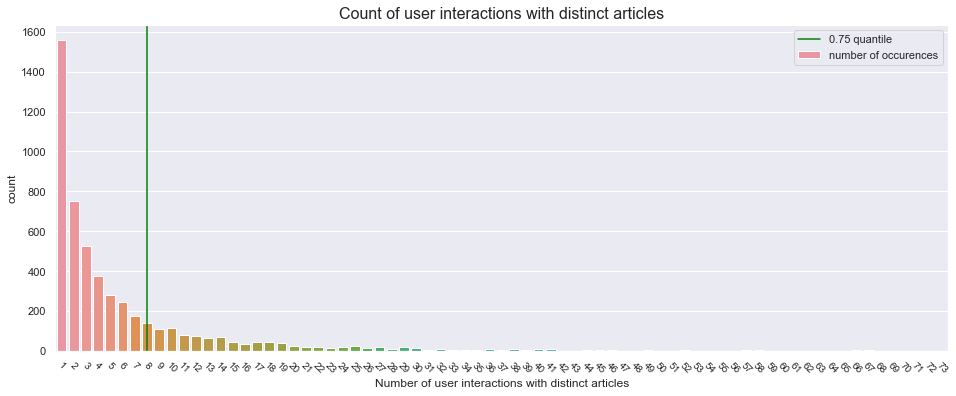

In [12]:
fig, ax = plt.subplots()
c = sns.countplot(x='distinct_articles', data=user_interact, ax=ax)
ax.set_xlabel('Number of user interactions with distinct articles')
ax.set_xticklabels(c.get_xticks()+1, fontsize=10, rotation=-45)
ax.set_title('Count of user interactions with distinct articles', fontsize=16)
ax.axvline(user_interact.distinct_articles.quantile(0.75), color='green')
plt.legend(('0.75 quantile','number of occurences'), loc='upper right');

In [13]:
(user_interact.distinct_articles==1).sum()

1557

Similarly, we can see that most of the users have one interaction with articles (1557 users) and most of the users  have less than 8 interactions with distinct articles (aprox. 75% of users).

In [14]:
# Fill in the median and maximum number of user_article interactios below
median_val = user_interact.distinct_articles.quantile(0.5)
print(f'50% of individuals interact with {median_val} of articles or fewer.')
max_views_by_user = user_interact.total_interactions.max()
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3.0 of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` __Exploring and removing duplicate articles from the `df_content` dataframe.__

In [15]:
print(f'Number of articles: {df_content.shape[0]}')
print(f'Number of unique articles: {df_content.article_id.nunique()}')
print(f'Number of repeated articles: {df_content.article_id.duplicated().sum()}')

Number of articles: 1056
Number of unique articles: 1051
Number of repeated articles: 5


In [16]:
repeated_art_ids = df_content[df_content.article_id.duplicated()].article_id.values
repeated_art_ids

array([ 50, 221, 398, 577, 232])

In [17]:
print('Repeated articles:')
repeated_art = df_content[df_content.article_id.isin(repeated_art_ids)].sort_values('article_id')
repeated_art

Repeated articles:


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [18]:
print(f'length of one article_id 50 is {len(repeated_art.doc_body.iloc[0])}')
print(f'length of other article_id 50 is {len(repeated_art.doc_body.iloc[1])}')

length of one article_id 50 is 9903
length of other article_id 50 is 10869


In [19]:
repeated_art.doc_body.iloc[0][500:1000]

'--------------\r\n\r\nGRAPH-BASED MACHINE LEARNING: PART I\r\nCOMMUNITY DETECTION AT SCALE\r\nDuring the seven-week Insight Data Engineering Fellows Program recent grads and experienced software engineers learn the latest open source technologies by building a data platform to handle large, real-time datasets.\r\n\r\nSebastien Dery (now a Data Science Engineer at Yewno ) discusses his project on community detection on large datasets.\r\n\r\n\r\n---------------------------------------------------------------------'

In [20]:
repeated_art.doc_body.iloc[1][500:1000]

'SED MACHINE LEARNING: PART 2\r\nCOMMUNITY DETECTION AT SCALE\r\nDuring the seven-week Insight Data Engineering Fellows Program recent grads and experienced software engineers learn the latest open source technologies by building a data platform to handle large, real-time datasets.\r\n\r\nSebastien Dery (now a Data Science Engineer at Yewno ) discusses his project on community detection on large datasets.\r\n\r\n\r\n--------------------------------------------------------------------------------\r\n\r\n#tltr : Gra'

Looks like the article was edited, saved again and therefore it maintained the same id.

In [21]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', inplace=True)

# Sanity check (there should be zero duplicated ids)
df_content.article_id.duplicated().sum()

0

Let's check the size of document bodies and descriptions:

In [22]:
# Let's drop nans, to make it simple (won't affect much statistics of body and description mean length)
docs = df_content[['doc_body','doc_description']].dropna()
docs.head()

,doc_body,doc_description
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c..."
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...


In [23]:
docs.applymap(lambda x: len(x)).describe()

,doc_body,doc_description
count,1034.000000,1034.000000
mean,8636.222437,171.312379
std,6940.797936,89.819385
min,4.000000,18.000000
25%,4301.500000,119.250000
50%,6844.000000,156.500000
75%,11802.500000,198.000000
max,60243.000000,763.000000


As we see, the mean length of document bodies is 8636 characters and document descriptions is 171 characters.

`3.` __We find:__

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [24]:
unique_articles = df.article_id.nunique()
print(f'The number of unique articles that have at least one interaction: {unique_articles}')

total_articles = df_content.article_id.nunique()
print(f'The number of unique articles on the IBM platform: {total_articles}')

unique_users = df.email.nunique()
print(f'The number of unique users: {unique_users}')

user_article_interactions = df.shape[0]
print(f'The number of user-article interactions: {user_article_interactions}')

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Finding the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [25]:
df.article_id.value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [26]:
most_viewed_article_id = str(df.article_id.value_counts().index[0])
print(f'The most viewed article_id in the dataset {most_viewed_article_id}')

max_views = df.article_id.value_counts().iloc[0]
print(f'The most viewed article in the dataset was viewed {max_views} times')

The most viewed article_id in the dataset 1429.0
The most viewed article in the dataset was viewed 937 times


In [27]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [28]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Since we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  Hence, the popularity of an article can be based on how often an article was interacted with.

`1.` __Function to return the `n` top articles ordered with most interactions as the top:__

In [93]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    unique_articles = df[['article_id','title']].drop_duplicates().set_index('article_id')
    
    top_articles_ids = get_top_article_ids(n, df)
    top_articles = [unique_articles.loc[i].title for i in top_articles_ids]
    
    # Applying drop_duplicates won't preserve order of ids (instead we drop all repeated articles in the beginning)
    # top_articles = df[df.article_id.isin(top_articles_ids)]['title'].drop_duplicates().to_list()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    top_articles_ids = df.article_id.value_counts().index[:n].to_list()
 
    return top_articles_ids # Return the top article ids

In [94]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [31]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` __Function to reformat the `df` dataframe to be shaped with users as the rows and articles as the columns.__  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [32]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id','article_id'])['title'].count().unstack()
    user_item = user_item.applymap(lambda x: 0 if np.isnan(x) else 1)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [33]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` __The function below takes a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.__

In [34]:
def find_similar_users(user_id, user_item=user_item, return_sims=False):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    return_sims - (bool) return similarity measures between users
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    similarities - (list) an orderd list of similarity measures (dot products)
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user, excluding him/herself
    sims = user_item.drop(user_id).dot(user_item.loc[user_id])

    # sort by similarity
    sims.sort_values(ascending=False, inplace=True)
    
    # create list of just the ids
    most_similar_users = sims.index.to_list()
    
    # list of similarities
    similarities = sims.to_list()
    
    if return_sims:
        return most_similar_users, similarities

    return most_similar_users # return a list of the users in order from most to least similar
        

In [35]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))
u, s = find_similar_users(46,return_sims=True)
print("\nThe 10 most similar users to user 46 are: {}\nSimilarities for top 10 most similar are {}".format(u[:10],s[:10]))


The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]

The 10 most similar users to user 46 are: [4201, 3782, 23, 203, 4459, 2982, 98, 3764, 290, 49]
Similarities for top 10 most similar are [40, 26, 26, 18, 18, 17, 16, 16, 16, 15]


`3.` __Now that we have a function that provides the most similar users to each user, we use these users to find articles we can recommend.__

In [36]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    unique_articles = df[['article_id','title']].drop_duplicates().set_index('article_id')
    article_names = [unique_articles.loc[float(i)].title for i in article_ids]
    
    # Drop duplicates won't necessarily maintain order
    # article_names = df[df.article_id.isin(article_ids)]['title'].drop_duplicates().to_list()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id].index[user_item.loc[user_id]==1].to_list()
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    similar_users = find_similar_users(user_id)
    articles_seen, _ = get_user_articles(user_id)
    
    recs = np.array([])
    
    for sim_usr in similar_users:
        sim_usr_seen_art, _ = get_user_articles(sim_usr)
        
        # New recommendation: articles not seen by user, which similar user has seen
        new_recs = np.setdiff1d(sim_usr_seen_art, articles_seen)
        
        recs = np.unique(np.concatenate((recs, new_recs), axis=0))
        if len(recs)>m:
            break
    
    recs = recs[:m]
    return recs # return your recommendations for this user_id    

In [37]:
print('Articles seen by user 2:')
get_user_articles(2)[1]

Articles seen by user 2:


['using deep learning to reconstruct high-resolution audio',
 'build a python app on the streaming analytics service',
 'gosales transactions for naive bayes model',
 'healthcare python streaming application demo',
 'use r dataframes & ibm watson natural language understanding',
 'use xgboost, scikit-learn & ibm watson machine learning apis']

In [38]:
print('Return 10 recommendations for user 2:')
get_article_names(user_user_recs(2, 10))

Return 10 recommendations for user 2:


['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'working interactively with rstudio and notebooks in dsx',
 'ensemble learning to improve machine learning results',
 'deep learning with tensorflow course by big data university',
 'modern machine learning algorithms',
 'transfer learning for flight delay prediction via variational autoencoders',
 'the 3 kinds of context: machine learning and the art of the frame',
 'how to choose a project to practice data science']

In [39]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` __Now we are going to improve the consistency of the `user_user_recs` function from above.__

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we choose articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function you wrote earlier.

In [70]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id (index) - is a neighbor user_id
                    similarity (column) - measure of the similarity of each user to the provided user_id
                    num_interactions (column) - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    sim_users, sims = find_similar_users(user_id, return_sims=True)

    ag = df[df.user_id.isin(sim_users)].groupby('user_id').agg(
        num_interactions=('user_id','count')
    )
    ag.rename_axis('neighbor_id', inplace=True)

    usr_sim = pd.DataFrame(index=pd.Index(name='neighbor_id',data=sim_users), data=sims, columns=['similarity'],)
    neighbors_df = ag.merge(usr_sim,on='neighbor_id', how='inner')
    neighbors_df.sort_values(['similarity', 'num_interactions'],ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    neighbors_df = get_top_sorted_users(user_id)
    articles_seen, _ = get_user_articles(user_id)
    
    recs = np.array([])
    for sim_usr in neighbors_df.index:
        neighbor_seen, _ = get_user_articles(sim_usr)
        not_seen = np.setdiff1d(neighbor_seen, articles_seen)
        not_seen_not_rec = np.setdiff1d(not_seen, recs)
        
        # Sort articles not seen and not in recommendations list by most total interactions
        not_seen_not_rec_sorted = sort_by_total_interactions(not_seen_not_rec)

        # We are ordering recommendations by user similarity articles and then by most interactions
        recs = np.concatenate((recs,not_seen_not_rec_sorted), axis=0)
        if recs.shape[0]>m:
            recs = recs[:m]
            break
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

def sort_by_total_interactions(articles):
    '''
    INPUT:
    articles - (list) articles ids
    
    OUTPUT:
    sorted_idxs - (list) a list of articles ids sorted by most total interactions 
    '''
    sorted_idxs = df[df.article_id.isin(articles)].article_id.value_counts().index.to_list()
    return sorted_idxs

In [71]:
user_user_recs_part2(10)

(array([1431., 1364., 1293., 1162., 1436., 1351., 1393., 1160., 1354.,
        1368.]),
 ['visualize car data with brunel',
  'predicting churn with the spss random tree algorithm',
  'finding optimal locations of new store using decision optimization',
  'analyze energy consumption in buildings',
  'welcome to pixiedust',
  'model bike sharing data with spss',
  'the nurse assignment problem',
  'analyze accident reports on amazon emr spark',
  'movie recommender system with spark machine learning',
  'putting a human face on machine learning'])

In [72]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330. 1427. 1364. 1170. 1162. 1304. 1351. 1160. 1354. 1368.]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` __We use the functions from above to correctly fill in the solutions to the dictionary below.  Then we test it against the solution.__

In [75]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = find_similar_users(131)[9]# Find the 10th most similar user to user 131

In [76]:
## Dictionary Test
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` __A few questions:__

- __If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.__

- __Is there a better way we might make recommendations for new users?__

Given a new user, we won't have interactions between users and items. Hence, it won't be possible to create a neighborhood-based collaborative filtering recommendation since we would need interactions to find similar users (who have interacted with same items). 

One strategy then would be to use rank based recommendataions, recommending the most popular items. We could add that to a knowledge based recommendation system were users could filter by article type (e.g. programming languages, authors, frameworks, use cases, etc.) and we would recommend the most popular items matching the filters.

Another possibility would be to gather more data about the users (not available in our case). Information like age, gender, location, etc. could potentially help us find similar users, cluster users in groups, and so on. This could helps us recommend items even though we don't know what actually the new user likes initially.

`7.` __Using the existing functions, we provide the top 10 recommended articles for the a new user below.__  

In [95]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
# To treat all ids as strings we transform them from float
new_user_recs = [str(i) for i in get_top_article_ids(10)]


In [97]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` __We use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  One additional idea is that we might want to choose the most popular recommendations that meet our 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.__

In [ ]:
# TODO: implement text normalization + nltk (tokenize, stop words, stemming, lemmatization) + LDA
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that we have put together our content-based recommendation system, we use the cell below to write a summary explaining how the content based recommender works.  Possible improvements that could be made to our function

`TODO:` Experiment approach with pre-trained language models (GPT-2/3 when available, BERT)

<a href="https://github.com/huggingface/transformers/blob/master/notebooks/03-pipelines.ipynb">Huggingface implementation for feature extraction could help</a>

<a href="https://blog.insightdatascience.com/contextual-topic-identification-4291d256a032">LDA + BERT approach by Steve Shao</a>

`3.` We use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [98]:
#TODO

# make recommendations for a brand new user

# make a recommendations for a user who only has interacted with article id '1427.0'


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` We have already created a **user_item** matrix in **question 1** of **Part III** above.

In [99]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [100]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [ ]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = # use the built in to get the three matrices

**Provide your response here.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

In [ ]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [ ]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [ ]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': # letter here, 
    'How many movies can we make predictions for in the test set?': # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': # letter here
}

t.sol_4_test(sol_4_dict)

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [ ]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = # fit svd similar to above then use the cells below

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])